In [27]:
import pandas
import numpy as np
data = pandas.read_csv("TDOA与PDOA集中上传.csv")

import time
import numpy as np
class PDOADisplay:
    def __init__(self,filtwindow=10,dispBufferSize=1000,ElectLen=21.00,ZeroPoint=179.73,Anchors=[0x0AFC,0x5B2B,0x08D3,0x7BD3],PhaseOffset=[0,178.99,11.61,-130.48],Freq= 6.5e9):
        self.reset()
        # 以下参数用配置文件进行设置
        self.filtwindow = filtwindow;
        self.dispBufferSize = dispBufferSize;
        self.ElectLen = ElectLen;
        self.ZeroPoint = ZeroPoint;
        self.PhaseOffset = PhaseOffset;
        self.Freq = Freq;
        self.Anchors=Anchors;
    def reset(self):
        self.dataBuffer = {}
        self.filtBuffer = {}
    def step(self,frame):
        frame=np.array(frame)
        ret = []
        for tag in np.unique(frame[:,2]):
            dataslice = np.zeros((len(self.Anchors),6))+ np.nan;
            for j in range(len(self.Anchors)):
                if np.any(np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag)):
                    dataslice[j,:]=frame[np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag),:]
            if(np.any(np.isfinite(dataslice))):
                TOA = dataslice[:,3];
                POA_SYNC = dataslice[:,4];
                POA_REPLY = dataslice[:,5];
                POA_SYNC = np.exp(POA_SYNC*2j*np.pi/256);
                POA_REPLY = np.exp(POA_REPLY*2j*np.pi/256);
                
                PDOA_SYNC = POA_SYNC*np.conj(POA_SYNC[0]);
                PDOA_REPLY = POA_REPLY*np.conj(POA_REPLY[0]);
                PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
                
                PDOA_CAL = PDOA * np.exp(1j*np.pi/180 * np.array(self.PhaseOffset)[None,...])
                pdoa = abs(np.fft.fft(PDOA_CAL,1024,axis=1));
                if tag not in self.filtBuffer:self.filtBuffer[tag]=[]
                self.filtBuffer[tag].append(pdoa[None,...])
                self.filtBuffer[tag]=self.filtBuffer[tag][-self.filtwindow:]
                pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)
                aoa=np.mod(0.5+np.argmax(pdoa,1)/1024,1)-0.5;
                aoa = aoa / (self.ElectLen /(3e11/self.Freq));
                aoa[np.abs(aoa)>1]=aoa[np.abs(aoa)>1]/np.abs(aoa[np.abs(aoa)>1]); # 限幅到-1~1
                aoa_cal=aoa;
                aoa_cal = np.arcsin(aoa)*180/np.pi;
                aoa_cal = np.arcsin(np.sin((aoa_cal + self.ZeroPoint)*np.pi/180))*180/np.pi;
                ret.append([[tag, frame[0,0],aoa_cal[0]]]) 
        return ret
                # if tag not in self.dataBuffer:self.dataBuffer[tag]=[]
                # self.dataBuffer[tag].append(np.array([[frame[0,0],aoa_cal[0]]]))
                # self.dataBuffer[tag]=self.dataBuffer[tag][-self.dispBufferSize:]
    def show(self,tag):
        return np.concatenate(self.dataBuffer[tag],0)
    
    def test(self, frame):
        frame=np.array(frame)
        ret = []
        for tag in np.unique(frame[:,2]):
            dataslice = np.zeros((len(self.Anchors),6))+ np.nan;
            for j in range(len(self.Anchors)):
                if np.any(np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag)):
                    dataslice[j,:]=frame[np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag),:]
            if(np.any(np.isfinite(dataslice))):
                TOA = dataslice[:,3];
                POA_SYNC = dataslice[:,4];
                POA_REPLY = dataslice[:,5];
                POA_SYNC = np.exp(POA_SYNC*2j*np.pi/256);
                POA_REPLY = np.exp(POA_REPLY*2j*np.pi/256);
                
                PDOA_SYNC = POA_SYNC*np.conj(POA_SYNC[0]);
                PDOA_REPLY = POA_REPLY*np.conj(POA_REPLY[0]);
                PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
                
                PDOA_CAL = PDOA * np.exp(1j*np.pi/180 * np.array(self.PhaseOffset)[None,...])
                pdoa = abs(np.fft.fft(PDOA_CAL,1024,axis=1));
                if tag not in self.filtBuffer:self.filtBuffer[tag]=[]
                self.filtBuffer[tag].append(pdoa[None,...])
                self.filtBuffer[tag]=self.filtBuffer[tag][-self.filtwindow:]
                pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)
                aoa=np.mod(0.5+np.argmax(pdoa,1)/1024,1)-0.5;
                aoa = aoa / (self.ElectLen /(3e11/self.Freq));
                aoa[np.abs(aoa)>1]=aoa[np.abs(aoa)>1]/np.abs(aoa[np.abs(aoa)>1]); # 限幅到-1~1
                aoa_cal=aoa;
                aoa_cal = np.arcsin(aoa)*180/np.pi;
                aoa_cal = np.arcsin(np.sin((aoa_cal + self.ZeroPoint)*np.pi/180))*180/np.pi;
                ret.append([tag, frame[0,0],aoa_cal[0]]) 
        return ret
    
cirDisp = PDOADisplay()
%time resu = data.groupby(by='rolling').apply(lambda x: cirDisp.test(x))
%time resu = np.concatenate(resu.values, 0)
%time resu = pandas.DataFrame(resu, columns=['tag','rolling','aoa'])
%time resu = resu.groupby(by='tag')

for k , v in a: print(k, v)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17164\3538858156.py:77: RuntimeWarning: invalid value encountered in divide
  PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17164\3538858156.py:84: RuntimeWarning: Mean of empty slice
  pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)


CPU times: total: 13.1 s
Wall time: 14.1 s
CPU times: total: 15.6 ms
Wall time: 19 ms
CPU times: total: 0 ns
Wall time: 956 µs
CPU times: total: 0 ns
Wall time: 0 ns
2812.0             0       1     2
0      2812.0   273.0  0.27
2      2812.0   274.0  0.27
4      2812.0   275.0  0.27
6      2812.0   276.0  0.27
8      2812.0   277.0  0.27
...       ...     ...   ...
11444  2812.0  5995.0  0.27
11446  2812.0  5996.0  0.27
11448  2812.0  5997.0  0.27
11450  2812.0  5998.0  0.27
11452  2812.0  5999.0  0.27

[5727 rows x 3 columns]
17839.0              0       1          2
1      17839.0   273.0   0.024052
3      17839.0   274.0  -0.590846
5      17839.0   275.0  -0.344879
7      17839.0   276.0  -0.098923
9      17839.0   277.0   0.147026
...        ...     ...        ...
11445  17839.0  5995.0  68.602801
11447  17839.0  5996.0  68.602801
11449  17839.0  5997.0  68.938343
11451  17839.0  5998.0  69.976660
11453  17839.0  5999.0  70.334248

[5727 rows x 3 columns]


In [39]:
import socket

def send(data, s):
    start = 0 
    while True:
        send_data = data[start: start + 10000]
        s.sendto(send_data, ('127.0.0.1', 9999))
        start += 10000
        if start >= len(data):
            break


file = 'pickle_file1.dat'
data = open(file, 'rb').read()

# 创建 socket 对象
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

# 获取本地主机名和端口号
host = '127.0.0.1'
port = 9999

send(data, s )

# 关闭 socket
s.close()


2
17839.0 9455     5000.0
9457     5001.0
9459     5002.0
9461     5003.0
9463     5004.0
          ...  
11445    5995.0
11447    5996.0
11449    5997.0
11451    5998.0
11453    5999.0
Name: rolling, Length: 1000, dtype: float64 9455     79.040519
9457     78.425646
9459     78.425646
9461     79.690585
9463     79.040519
           ...    
11445    68.602801
11447    68.602801
11449    68.938343
11451    69.976660
11453    70.334248
Name: aoa, Length: 1000, dtype: float64


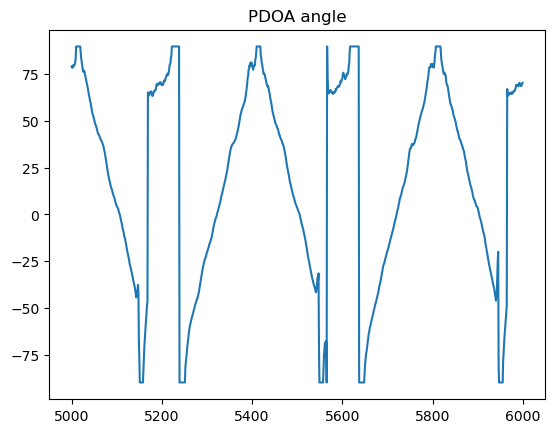

In [22]:
print(len(resu))
# resu['tag'] == 277
for k, v in resu:
    if k == 0x45AF:
        v = v[-1000:]
        print(k, v['rolling'], v['aoa'])
        import matplotlib.pyplot as plt
        plt.plot(v['rolling'], v['aoa'])
        plt.title("PDOA angle")
        plt.show()


In [13]:
import pandas
import numpy as np
data = pandas.read_csv("TDOA与PDOA集中上传.csv")
resu = []
rolling = None
resu2 = []
for _,i in data.iterrows():
    if rolling != i['rolling']:
        if len(resu2)>0:
            resu2 = pandas.DataFrame(resu2)
            resu.append(resu2)
        rolling = i['rolling']
        resu2 = []
    resu2.append(i)
del resu2 
del rolling 
del i 
del data

In [14]:
Anchors = [0x0AFC,0x5B2B,0x08D3,0x7BD3] # 从目前收到的anchor里选择.需要保证顺序可控
tag = 0x45AF # 下拉框选择
filtwindow = 10 # 拖动条 1~100

In [15]:
import time
import numpy as np
class PDOADisplay:
    def __init__(self,filtwindow=10,dispBufferSize=1000,ElectLen=21.00,ZeroPoint=179.73,Anchors=[0x0AFC,0x5B2B,0x08D3,0x7BD3],PhaseOffset=[0,178.99,11.61,-130.48],Freq= 6.5e9):
        self.reset()
        # 以下参数用配置文件进行设置
        self.filtwindow = filtwindow;
        self.dispBufferSize = dispBufferSize;
        self.ElectLen = ElectLen;
        self.ZeroPoint = ZeroPoint;
        self.PhaseOffset = PhaseOffset;
        self.Freq = Freq;
        self.Anchors=Anchors;
    def reset(self):
        self.dataBuffer = {}
        self.filtBuffer = {}
    def step(self,frame):
        frame=np.array(frame)
        for tag in np.unique(frame[:,2]):
            dataslice = np.zeros((len(self.Anchors),6))+ np.nan;
            for j in range(len(self.Anchors)):
                if np.any(np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag)):
                    dataslice[j,:]=frame[np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag),:]
            if(np.any(np.isfinite(dataslice))):
                TOA = dataslice[:,3];
                POA_SYNC = dataslice[:,4];
                POA_REPLY = dataslice[:,5];
                POA_SYNC = np.exp(POA_SYNC*2j*np.pi/256);
                POA_REPLY = np.exp(POA_REPLY*2j*np.pi/256);
                
                PDOA_SYNC = POA_SYNC*np.conj(POA_SYNC[0]);
                PDOA_REPLY = POA_REPLY*np.conj(POA_REPLY[0]);
                PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
                
                PDOA_CAL = PDOA * np.exp(1j*np.pi/180 * np.array(self.PhaseOffset)[None,...])
                pdoa = abs(np.fft.fft(PDOA_CAL,1024,axis=1));
                if tag not in self.filtBuffer:self.filtBuffer[tag]=[]
                self.filtBuffer[tag].append(pdoa[None,...])
                self.filtBuffer[tag]=self.filtBuffer[tag][-self.filtwindow:]
                pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)
                aoa=np.mod(0.5+np.argmax(pdoa,1)/1024,1)-0.5;
                aoa = aoa / (self.ElectLen /(3e11/self.Freq));
                aoa[np.abs(aoa)>1]=aoa[np.abs(aoa)>1]/np.abs(aoa[np.abs(aoa)>1]); # 限幅到-1~1
                aoa_cal=aoa;
                aoa_cal = np.arcsin(aoa)*180/np.pi;
                aoa_cal = np.arcsin(np.sin((aoa_cal + self.ZeroPoint)*np.pi/180))*180/np.pi;
                if tag not in self.dataBuffer:self.dataBuffer[tag]=[]
                self.dataBuffer[tag].append(np.array([[frame[0,0],aoa_cal[0]]]))
                self.dataBuffer[tag]=self.dataBuffer[tag][-self.dispBufferSize:]
    def show(self,tag):
        return np.concatenate(self.dataBuffer[tag],0)

In [5]:

cirDisp = PDOADisplay()
t0=time.time()
for frame in resu:#tqdm.tqdm(resu):
    cirDisp.step(frame)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22628\2062412459.py:33: RuntimeWarning: invalid value encountered in divide
  PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22628\2062412459.py:40: RuntimeWarning: Mean of empty slice
  pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22628\2062412459.py:33: RuntimeWarning: invalid value encountered in divide
  PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22628\2062412459.py:40: RuntimeWarning: Mean of empty slice
  pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)


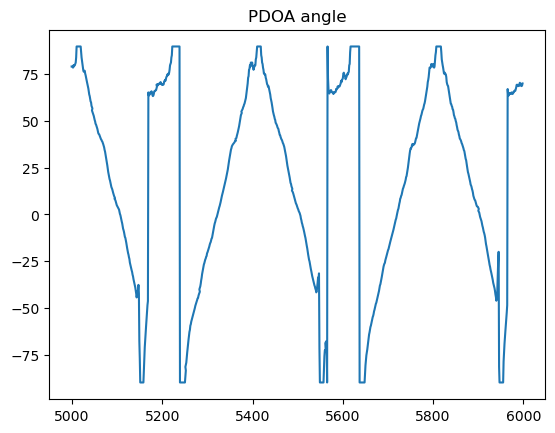

In [6]:
import matplotlib.pyplot as plt
d=cirDisp.show(tag)
plt.plot(d[:,0],d[:,1])
plt.title("PDOA angle")
plt.show()